In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sakshitanwar1","key":"0084467a50f63d0d62e0c906f9fa234e"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Downloading the data from kaggle
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign


100% 325M/325M [00:17<00:00, 21.0MB/s]
100% 325M/325M [00:17<00:00, 19.6MB/s]


In [7]:
# Extract the zipfile

import zipfile
zip_ref = zipfile.ZipFile('/content/skin-cancer-malignant-vs-benign.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [8]:
import tensorflow as tf
from  tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten,BatchNormalization,Dropout


In [9]:
from keras.applications.vgg16 import VGG16

In [10]:
# Generator

train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size=(256,256)
)

Found 2637 files belonging to 2 classes.
Found 660 files belonging to 2 classes.


In [12]:
## Create conv_base model
conv_base = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (150,150,3)  # you can give any image size
)

58889256/58889256 [==============================] - 4s 0us/step


In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [14]:
# Model Building
model=Sequential()

model.add(conv_base)   # Base model VGG16 used as top
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [16]:
# VGG16 top is false
conv_base.trainable = False

In [17]:
# Normalize

def process(image,label):
  image = tf.cast(image/255. ,tf.float32)
  return image,label

ts = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [18]:
from keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.utils import img_to_array, array_to_img, load_img

In [19]:
# Use Data Augmentation
# Here I used ImageData Generator

batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(150,150),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    '/content/test',
    target_size=(150,150),
    batch_size=batch_size,
    class_mode='binary')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [20]:
# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [21]:
# Fit the mode
# here I used fit_generator because ImageDataGenerator is used for Data Augumentation
history = model.fit_generator(
    train_generator,
    epochs=10,
    validation_data=validation_generator)

<ipython-input-21-310a0129e9d7>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
83/83 [==============================] - 39s 327ms/step - loss: 0.4878 - accuracy: 0.7766 - val_loss: 0.4033 - val_accuracy: 0.8258
Epoch 2/10
83/83 [==============================] - 26s 316ms/step - loss: 0.3940 - accuracy: 0.8210 - val_loss: 0.3747 - val_accuracy: 0.8318
Epoch 3/10
83/83 [==============================] - 26s 314ms/step - loss: 0.3454 - accuracy: 0.8419 - val_loss: 0.3445 - val_accuracy: 0.8394
Epoch 4/10
83/83 [==============================] - 30s 364ms/step - loss: 0.3245 - accuracy: 0.8453 - val_loss: 0.3724 - val_accuracy: 0.8318
Epoch 5/10
83/83 [==============================] - 27s 324ms/step - loss: 0.3048 - accuracy: 0.8677 - val_loss: 0.3308 - val_accuracy: 0.8379
Epoch 6/10
83/83 [==============================] - 27s 328ms/step - loss: 0.2999 - accuracy: 0.8661 - val_loss: 0.3356 - val_accuracy: 0.8379
Epoch 7/10
83/83 [==============================] - 26s 313ms/step - loss: 0.2786 - accuracy: 0.8802 - val_loss: 0.3361 - val_accuracy: 0.8424

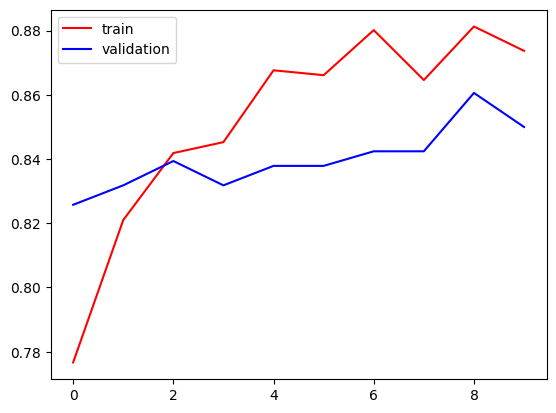

In [22]:
import matplotlib.pyplot as plt


# Accuracuy Plot
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

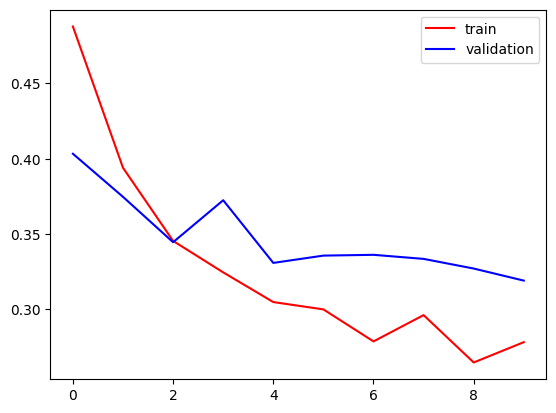

In [23]:
# Ploting the Loss
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [24]:
# Saving the model
model.save('skin_cancer_model.h5')

In [25]:
# Loading the model
model = keras.models.load_model('skin_cancer_model.h5')


In [26]:
## Testing the image
import cv2

In [27]:
test_img = cv2.imread('/content/test/benign/1.jpg')

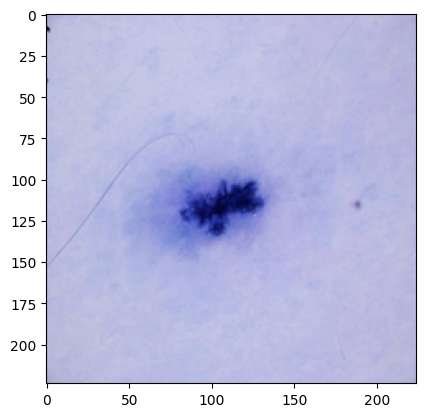

In [28]:
plt.imshow(test_img)

In [29]:
test_img.shape

(224, 224, 3)

In [30]:
test_img = cv2.resize(test_img,(150,150))

In [31]:
test_input = test_img.reshape((1,150,150,3))

In [32]:
model.predict(test_input)

1/1 [==============================] - 1s 719ms/step


array([[1.]], dtype=float32)

In [33]:
## Testing the image malignant
test_img = cv2.imread('/content/test/malignant/1003.jpg')

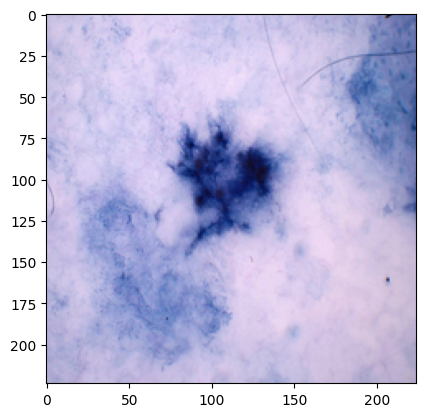

In [34]:
plt.imshow(test_img)

In [35]:
test_img = cv2.resize(test_img,(150,150))

In [36]:
test_input = test_img.reshape((1,150,150,3))

In [37]:
model.predict(test_input)

1/1 [==============================] - 0s 25ms/step


array([[0.00349927]], dtype=float32)